In [98]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import re
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)

In [2]:
url = 'https://www.boxofficemojo.com/chart/mpaa_title_lifetime_gross/?by_mpaa=R&ref_=bo_cso_ac'

response = requests.get(url)
page = response.text

soup = BeautifulSoup(page, 'lxml')

In [3]:
table = soup.find('table')
rows = [row for row in table.find_all('tr')]

In [4]:
movies = {}

for row in rows[1:201]:
    items = row.find_all('td')
    link = items[0].find('a')
    title, url = link.text, link['href']
    movies[title] = [url] + [i.text for i in items]
    
movies

{'Hostage': ['/title/tt0340163/?ref_=bo_cso_table_1',
  'Hostage',
  '801',
  '$34,639,939',
  '2,488',
  '2005'],
 'Man on the Moon': ['/title/tt0125664/?ref_=bo_cso_table_2',
  'Man on the Moon',
  '802',
  '$34,607,430',
  '2,489',
  '1999'],
 'Mississippi Burning': ['/title/tt0095647/?ref_=bo_cso_table_3',
  'Mississippi Burning',
  '803',
  '$34,603,943',
  '2,491',
  '1988'],
 'Monster': ['/title/tt0340855/?ref_=bo_cso_table_4',
  'Monster',
  '804',
  '$34,469,210',
  '2,496',
  '2003'],
 'The Doors': ['/title/tt0101761/?ref_=bo_cso_table_5',
  'The Doors',
  '805',
  '$34,416,893',
  '2,498',
  '1991'],
 'Eternal Sunshine of the Spotless Mind': ['/title/tt0338013/?ref_=bo_cso_table_6',
  'Eternal Sunshine of the Spotless Mind',
  '806',
  '$34,400,301',
  '2,499',
  '2004'],
 'The Foreigner': ['/title/tt1615160/?ref_=bo_cso_table_7',
  'The Foreigner',
  '807',
  '$34,393,507',
  '2,500',
  '2017'],
 'The Favourite': ['/title/tt5083738/?ref_=bo_cso_table_8',
  'The Favourite',


In [5]:
r_movies = pd.DataFrame(movies).T  #transpose
r_movies.columns = ['link_stub', 'movie_title', 'rank_g_movies', 
                    'lifetime_gross', 'rank_overall', 'year']

r_movies.head()

,link_stub,movie_title,rank_g_movies,lifetime_gross,rank_overall,year
Hostage,/title/tt0340163/?ref_=bo_cso_table_1,Hostage,801,"$34,639,939","2,488",2005
Man on the Moon,/title/tt0125664/?ref_=bo_cso_table_2,Man on the Moon,802,"$34,607,430","2,489",1999
Mississippi Burning,/title/tt0095647/?ref_=bo_cso_table_3,Mississippi Burning,803,"$34,603,943","2,491",1988
Monster,/title/tt0340855/?ref_=bo_cso_table_4,Monster,804,"$34,469,210","2,496",2003
The Doors,/title/tt0101761/?ref_=bo_cso_table_5,The Doors,805,"$34,416,893","2,498",1991


In [6]:
import dateutil.parser

def money_to_int(moneystring):
    moneystring = moneystring.replace('$', '').replace(',', '')
    return int(moneystring)

def runtime_to_minutes(runtimestring):
    runtime = runtimestring.split()
    try:
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

In [7]:
def get_movie_value(soup, field_name):
    
    '''Grab a value from Box Office Mojo HTML
    
    Takes a string attribute of a movie on the page and returns the string in
    the next sibling object (the value for that attribute) or None if nothing is found.
    '''
    
    obj = soup.find(text=re.compile(field_name))
    
    if not obj: 
        return None
    
    # this works for most of the values
    next_element = obj.findNext()
    
    if next_element:
        return next_element.text 
    else:
        return None

In [8]:
def get_movie_dict(link):
    
    base_url = 'https://www.boxofficemojo.com'
    
    #Create full url to scrape
    url = base_url + link
    
    #Request HTML and parse
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page,"lxml")

    
    headers = ['movie_title', 'domestic_total_gross', 'international_total_gross', 'worldwide_total_gross',
               'opening', 'budget','runtime_minutes', 'rating', 'release_date']
    
    #Get title
    title_string = soup.find('title').text
    title = title_string.split('-')[0].strip()

    #Get domestic gross
    raw_domestic_total_gross = (soup.find(class_='mojo-performance-summary-table')
                                    .find_all('span', class_='money')[0]
                                    .text
                               )
    domestic_total_gross = money_to_int(raw_domestic_total_gross)
    
    #Get international gross
    raw_international_total_gross = (soup.find(class_='mojo-performance-summary-table')
                                    .find_all('span', class_='money')[1]
                                    .text
                               )
    international_total_gross = money_to_int(raw_international_total_gross)
    
    #Get worldwide gross
    raw_worldwide_total_gross = (soup.find(class_='mojo-performance-summary-table')
                                    .find_all('span', class_='money')[-1]
                                    .text
                               )
    worldwide_total_gross = money_to_int(raw_worldwide_total_gross)
    
    #Get Domestic Opening 
    opening = get_movie_value(soup, 'Domestic Opening')
    
    #Get Budget
    budget = get_movie_value(soup, 'Budget')
    
    #Get runtime
    raw_runtime = get_movie_value(soup,'Running')
    runtime = runtime_to_minutes(raw_runtime)
    
    #Get rating
    rating = get_movie_value(soup,'MPAA')

    #Get release date
    raw_release_date = get_movie_value(soup,'Release Date').split('\n')[0]
    release_date = to_date(raw_release_date)
    
    #Create movie dictionary and return
    movie_dict = dict(zip(headers, [title,
                                domestic_total_gross,
                                international_total_gross,
                                worldwide_total_gross,
                                opening,
                                budget,
                                runtime,
                                rating, 
                                release_date]))

    return movie_dict

In [9]:
r_movies_page_info_list = []

for link in r_movies.link_stub:
    r_movies_page_info_list.append(get_movie_dict(link))

In [10]:
r_movies_page_info = pd.DataFrame(r_movies_page_info_list)  #convert list of dict to df
r_movies_page_info.set_index('movie_title', inplace=True)

r_movies_page_info

,domestic_total_gross,international_total_gross,worldwide_total_gross,opening,budget,runtime_minutes,rating,release_date
movie_title,,,,,,,,
Hostage,34639939,43023617,77663556,"$9,800,000",None,113.0,R,2005-03-10
Man on the Moon,34607430,12827000,47434430,"$7,515,585","$82,000,000",118.0,R,1999-12-22
Mississippi Burning,34603943,34603943,34603943,"$225,034",None,128.0,None,1988-12-09
Monster,34469210,24000000,58469210,"$86,831","$8,000,000",109.0,R,2003-12-24
The Doors,34416893,34416893,34416893,"$9,151,800",None,140.0,R,1991-03-01
...,...,...,...,...,...,...,...,...
Sinister 2,27740955,25588195,53329150,"$10,542,116","$10,000,000",97.0,R,2015-08-19
Internal Affairs,27734391,27734391,27734391,"$5,043,516",None,115.0,None,1990-01-12
Oculus,27695246,16764705,44459951,"$12,005,402","$5,000,000",104.0,R,2014-04-09


In [11]:
df4 = pd.merge(r_movies, r_movies_page_info, on='movie_title')

In [12]:
df4

,link_stub,movie_title,rank_g_movies,lifetime_gross,rank_overall,year,domestic_total_gross,international_total_gross,worldwide_total_gross,opening,budget,runtime_minutes,rating,release_date
0,/title/tt0340163/?ref_=bo_cso_table_1,Hostage,801,"$34,639,939","2,488",2005,34639939,43023617,77663556,"$9,800,000",None,113.0,R,2005-03-10
1,/title/tt0125664/?ref_=bo_cso_table_2,Man on the Moon,802,"$34,607,430","2,489",1999,34607430,12827000,47434430,"$7,515,585","$82,000,000",118.0,R,1999-12-22
2,/title/tt0095647/?ref_=bo_cso_table_3,Mississippi Burning,803,"$34,603,943","2,491",1988,34603943,34603943,34603943,"$225,034",None,128.0,None,1988-12-09
3,/title/tt0340855/?ref_=bo_cso_table_4,Monster,804,"$34,469,210","2,496",2003,34469210,24000000,58469210,"$86,831","$8,000,000",109.0,R,2003-12-24
4,/title/tt0101761/?ref_=bo_cso_table_5,The Doors,805,"$34,416,893","2,498",1991,34416893,34416893,34416893,"$9,151,800",None,140.0,R,1991-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,/title/tt2752772/?ref_=bo_cso_table_196,Sinister 2,996,"$27,740,955","2,929",2015,27740955,25588195,53329150,"$10,542,116","$10,000,000",97.0,R,2015-08-19
192,/title/tt0099850/?ref_=bo_cso_table_197,Internal Affairs,997,"$27,734,391","2,930",1990,27734391,27734391,27734391,"$5,043,516",None,115.0,None,1990-01-12
193,/title/tt2388715/?ref_=bo_cso_table_198,Oculus,998,"$27,695,246","2,931",2014,27695246,16764705,44459951,"$12,005,402","$5,000,000",104.0,R,2014-04-09
194,/title/tt1233227/?ref_=bo_cso_table_199,Saw VI,999,"$27,693,292","2,932",2009,27693292,40540862,68234154,"$14,118,444","$11,000,000",90.0,R,2009-10-22


In [13]:
df4.to_csv('df4.csv')

In [14]:
pd.read_csv('movies_data')

,Unnamed: 0,Unnamed: 0.1,link_stub,movie_title,rank_g_movies,lifetime_gross,rank_overall,year,domestic_total_gross,international_total_gross,worldwide_total_gross,opening,budget,runtime_minutes,rating,release_date
0,0,0,/title/tt0335345/?ref_=bo_cso_table_1,The Passion of the Christ,1,"$370,782,930",47,2004,370782930,241271576,241271576,"$83,848,082","$30,000,000",127.0,R,2004-02-25
1,1,1,/title/tt1431045/?ref_=bo_cso_table_2,Deadpool,2,"$363,070,709",51,2016,363070709,419766082,419766082,"$132,434,639","$58,000,000",108.0,R,2016-02-09
2,2,2,/title/tt2179136/?ref_=bo_cso_table_3,American Sniper,3,"$350,126,372",56,2014,350126372,197300000,197300000,"$633,456","$58,800,000",133.0,R,2014-12-25
3,3,3,/title/tt7286456/?ref_=bo_cso_table_4,Joker,4,"$335,451,311",62,2019,335451311,738968073,738968073,"$96,202,337","$55,000,000",122.0,R,2019-10-02
4,4,4,/title/tt1396484/?ref_=bo_cso_table_5,It,5,"$328,828,874",69,2017,328828874,372967570,372967570,"$123,403,419","$35,000,000",135.0,R,2017-09-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,192,192,/title/tt1259528/?ref_=bo_cso_table_196,Den of Thieves,596,"$44,947,622","1,949",2018,44947622,35562000,35562000,"$15,206,108",NaN,140.0,R,2018-01-18
590,193,193,/title/tt1666185/?ref_=bo_cso_table_197,All Eyez on Me,597,"$44,922,302","1,952",2017,44922302,10746396,10746396,"$26,435,354","$40,000,000",139.0,R,2017-06-15
591,194,194,/title/tt0077504/?ref_=bo_cso_table_198,The End,598,"$44,917,151","1,953",1978,44917151,44917151,44917151,NaN,NaN,100.0,NaN,1978-05-10
592,195,195,/title/tt1385867/?ref_=bo_cso_table_199,Cop Out,599,"$44,875,481","1,955",2010,44875481,10735520,10735520,"$18,211,126","$30,000,000",107.0,R,2010-02-26


In [15]:
df = pd.read_csv('df.csv')
df1 = pd.read_csv('df1.csv')
df2 = pd.read_csv('df2.csv')
df3 = pd.read_csv('df3.csv')
df4 = pd.read_csv('df4.csv')

In [16]:
frames = [df, df1, df2, df3, df4]

In [17]:
result = pd.concat(frames, ignore_index=True)

In [18]:
result_1 = result

In [19]:
result.reset_index(drop=True)

,Unnamed: 0,link_stub,movie_title,rank_g_movies,lifetime_gross,rank_overall,year,domestic_total_gross,international_total_gross,worldwide_total_gross,opening,budget,runtime_minutes,rating,release_date
0,0,/title/tt0335345/?ref_=bo_cso_table_1,The Passion of the Christ,1,"$370,782,930",47,2004,370782930,241271576,241271576,"$83,848,082","$30,000,000",127.0,R,2004-02-25
1,1,/title/tt1431045/?ref_=bo_cso_table_2,Deadpool,2,"$363,070,709",51,2016,363070709,419766082,419766082,"$132,434,639","$58,000,000",108.0,R,2016-02-09
2,2,/title/tt2179136/?ref_=bo_cso_table_3,American Sniper,3,"$350,126,372",56,2014,350126372,197300000,197300000,"$633,456","$58,800,000",133.0,R,2014-12-25
3,3,/title/tt7286456/?ref_=bo_cso_table_4,Joker,4,"$335,451,311",62,2019,335451311,738968073,738968073,"$96,202,337","$55,000,000",122.0,R,2019-10-02
4,4,/title/tt1396484/?ref_=bo_cso_table_5,It,5,"$328,828,874",69,2017,328828874,372967570,372967570,"$123,403,419","$35,000,000",135.0,R,2017-09-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,191,/title/tt2752772/?ref_=bo_cso_table_196,Sinister 2,996,"$27,740,955","2,929",2015,27740955,25588195,53329150,"$10,542,116","$10,000,000",97.0,R,2015-08-19
984,192,/title/tt0099850/?ref_=bo_cso_table_197,Internal Affairs,997,"$27,734,391","2,930",1990,27734391,27734391,27734391,"$5,043,516",NaN,115.0,NaN,1990-01-12
985,193,/title/tt2388715/?ref_=bo_cso_table_198,Oculus,998,"$27,695,246","2,931",2014,27695246,16764705,44459951,"$12,005,402","$5,000,000",104.0,R,2014-04-09
986,194,/title/tt1233227/?ref_=bo_cso_table_199,Saw VI,999,"$27,693,292","2,932",2009,27693292,40540862,68234154,"$14,118,444","$11,000,000",90.0,R,2009-10-22


In [20]:
result.drop(df.filter(regex="Unname"),axis=1, inplace=True)

In [21]:
result

,link_stub,movie_title,rank_g_movies,lifetime_gross,rank_overall,year,domestic_total_gross,international_total_gross,worldwide_total_gross,opening,budget,runtime_minutes,rating,release_date
0,/title/tt0335345/?ref_=bo_cso_table_1,The Passion of the Christ,1,"$370,782,930",47,2004,370782930,241271576,241271576,"$83,848,082","$30,000,000",127.0,R,2004-02-25
1,/title/tt1431045/?ref_=bo_cso_table_2,Deadpool,2,"$363,070,709",51,2016,363070709,419766082,419766082,"$132,434,639","$58,000,000",108.0,R,2016-02-09
2,/title/tt2179136/?ref_=bo_cso_table_3,American Sniper,3,"$350,126,372",56,2014,350126372,197300000,197300000,"$633,456","$58,800,000",133.0,R,2014-12-25
3,/title/tt7286456/?ref_=bo_cso_table_4,Joker,4,"$335,451,311",62,2019,335451311,738968073,738968073,"$96,202,337","$55,000,000",122.0,R,2019-10-02
4,/title/tt1396484/?ref_=bo_cso_table_5,It,5,"$328,828,874",69,2017,328828874,372967570,372967570,"$123,403,419","$35,000,000",135.0,R,2017-09-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,/title/tt2752772/?ref_=bo_cso_table_196,Sinister 2,996,"$27,740,955","2,929",2015,27740955,25588195,53329150,"$10,542,116","$10,000,000",97.0,R,2015-08-19
984,/title/tt0099850/?ref_=bo_cso_table_197,Internal Affairs,997,"$27,734,391","2,930",1990,27734391,27734391,27734391,"$5,043,516",NaN,115.0,NaN,1990-01-12
985,/title/tt2388715/?ref_=bo_cso_table_198,Oculus,998,"$27,695,246","2,931",2014,27695246,16764705,44459951,"$12,005,402","$5,000,000",104.0,R,2014-04-09
986,/title/tt1233227/?ref_=bo_cso_table_199,Saw VI,999,"$27,693,292","2,932",2009,27693292,40540862,68234154,"$14,118,444","$11,000,000",90.0,R,2009-10-22


In [22]:
movie_data = result.drop(result.columns[[0, 2, 3, 4]], axis=1)
movie_data


,movie_title,year,domestic_total_gross,international_total_gross,worldwide_total_gross,opening,budget,runtime_minutes,rating,release_date
0,The Passion of the Christ,2004,370782930,241271576,241271576,"$83,848,082","$30,000,000",127.0,R,2004-02-25
1,Deadpool,2016,363070709,419766082,419766082,"$132,434,639","$58,000,000",108.0,R,2016-02-09
2,American Sniper,2014,350126372,197300000,197300000,"$633,456","$58,800,000",133.0,R,2014-12-25
3,Joker,2019,335451311,738968073,738968073,"$96,202,337","$55,000,000",122.0,R,2019-10-02
4,It,2017,328828874,372967570,372967570,"$123,403,419","$35,000,000",135.0,R,2017-09-06
...,...,...,...,...,...,...,...,...,...,...
983,Sinister 2,2015,27740955,25588195,53329150,"$10,542,116","$10,000,000",97.0,R,2015-08-19
984,Internal Affairs,1990,27734391,27734391,27734391,"$5,043,516",NaN,115.0,NaN,1990-01-12
985,Oculus,2014,27695246,16764705,44459951,"$12,005,402","$5,000,000",104.0,R,2014-04-09
986,Saw VI,2009,27693292,40540862,68234154,"$14,118,444","$11,000,000",90.0,R,2009-10-22


In [ ]:
movie_data.info()

In [ ]:
movie_data = movie_data.astype({"Name":'category', "Age":'int64'})

In [23]:
movie_data['opening'] = movie_data['opening'].str.replace('$','')
movie_data['opening'] = movie_data['opening'].str.replace(',', '')
movie_data['opening']

<ipython-input-23-36b0325be767>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  movie_data['opening'] = movie_data['opening'].str.replace('$','')


0       83848082
1      132434639
2         633456
3       96202337
4      123403419
         ...    
983     10542116
984      5043516
985     12005402
986     14118444
987     13051650
Name: opening, Length: 988, dtype: object

In [24]:
movie_data['budget'] = movie_data['budget'].str.replace('$','')
movie_data['budget'] = movie_data['budget'].str.replace(',', '')

<ipython-input-24-ce8753f75e01>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  movie_data['budget'] = movie_data['budget'].str.replace('$','')


In [25]:
movie_df = movie_data

In [30]:
movie_data['worldwide_total_gross'] = movie_data['domestic_total_gross'] + movie_data['international_total_gross']
movie_data.head()

,movie_title,year,domestic_total_gross,international_total_gross,worldwide_total_gross,opening,budget,runtime_minutes,rating,release_date
0,The Passion of the Christ,2004,370782930,241271576,612054506,83848082,30000000,127.0,R,2004-02-25
1,Deadpool,2016,363070709,419766082,782836791,132434639,58000000,108.0,R,2016-02-09
2,American Sniper,2014,350126372,197300000,547426372,633456,58800000,133.0,R,2014-12-25
3,Joker,2019,335451311,738968073,1074419384,96202337,55000000,122.0,R,2019-10-02
4,It,2017,328828874,372967570,701796444,123403419,35000000,135.0,R,2017-09-06


In [31]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988 entries, 0 to 987
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   movie_title                988 non-null    object 
 1   year                       988 non-null    int64  
 2   domestic_total_gross       988 non-null    int64  
 3   international_total_gross  988 non-null    int64  
 4   worldwide_total_gross      988 non-null    int64  
 5   opening                    950 non-null    object 
 6   budget                     648 non-null    object 
 7   runtime_minutes            969 non-null    float64
 8   rating                     812 non-null    object 
 9   release_date               988 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 77.3+ KB


In [34]:
movie_df = movie_data.dropna()
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610 entries, 0 to 986
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   movie_title                610 non-null    object 
 1   year                       610 non-null    int64  
 2   domestic_total_gross       610 non-null    int64  
 3   international_total_gross  610 non-null    int64  
 4   worldwide_total_gross      610 non-null    int64  
 5   opening                    610 non-null    object 
 6   budget                     610 non-null    object 
 7   runtime_minutes            610 non-null    float64
 8   rating                     610 non-null    object 
 9   release_date               610 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 52.4+ KB


In [35]:
movie_df['opening'] = movie_df['opening'].astype(int)

<ipython-input-35-576c0af1cc08>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df['opening'] = movie_df['opening'].astype(int)


In [36]:
movie_df['budget'] = movie_df['budget'].astype(int)

<ipython-input-36-0eb2879424bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df['budget'] = movie_df['budget'].astype(int)


In [37]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610 entries, 0 to 986
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   movie_title                610 non-null    object 
 1   year                       610 non-null    int64  
 2   domestic_total_gross       610 non-null    int64  
 3   international_total_gross  610 non-null    int64  
 4   worldwide_total_gross      610 non-null    int64  
 5   opening                    610 non-null    int64  
 6   budget                     610 non-null    int64  
 7   runtime_minutes            610 non-null    float64
 8   rating                     610 non-null    object 
 9   release_date               610 non-null    object 
dtypes: float64(1), int64(6), object(3)
memory usage: 52.4+ KB


In [111]:
movie_df.head()

,movie_title,year,domestic_total_gross,international_total_gross,worldwide_total_gross,opening,budget,runtime_minutes,rating,release_date,months
0,The Passion of the Christ,2004,370782930,241271576,612054506,83848082,30000000,127.0,R,2004-02-25,2
1,Deadpool,2016,363070709,419766082,782836791,132434639,58000000,108.0,R,2016-02-09,2
2,American Sniper,2014,350126372,197300000,547426372,633456,58800000,133.0,R,2014-12-25,12
3,Joker,2019,335451311,738968073,1074419384,96202337,55000000,122.0,R,2019-10-02,10
4,It,2017,328828874,372967570,701796444,123403419,35000000,135.0,R,2017-09-06,9


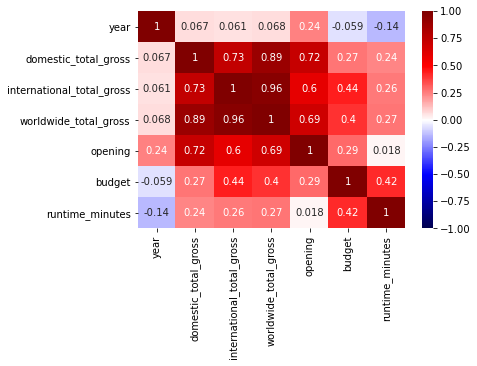

In [45]:
sns.heatmap(movie_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

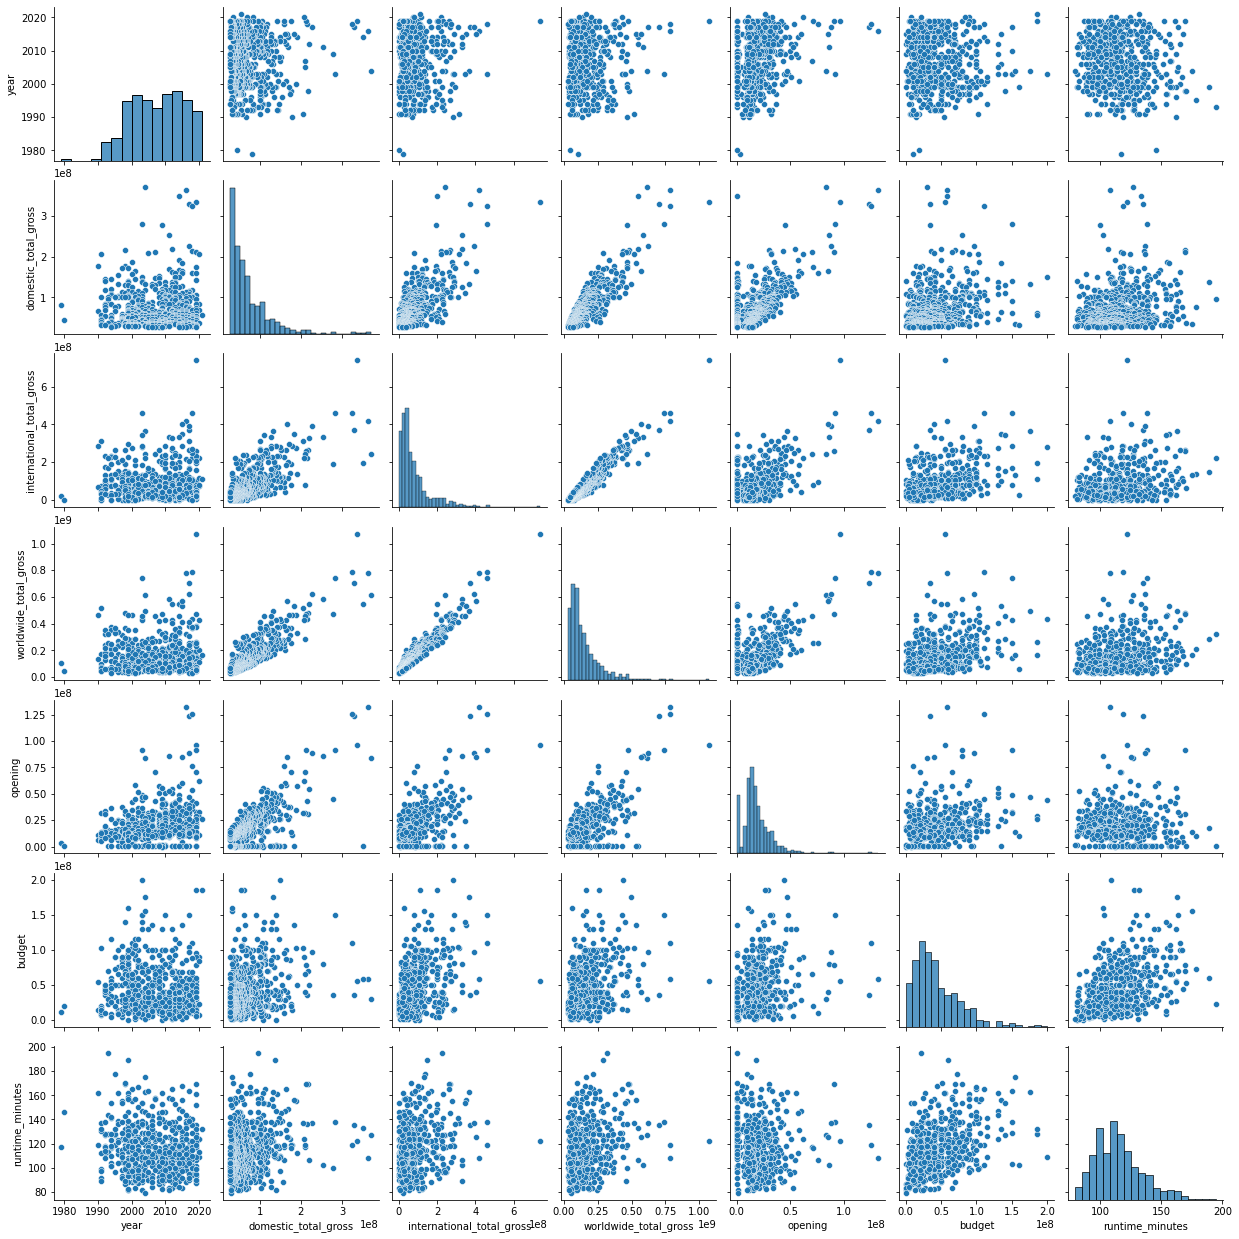

In [41]:
sns.pairplot(movie_df)

In [112]:
lr = LinearRegression()
lr.fit(movie_df[['budget', 'months','runtime_minutes']], 
       movie_df['worldwide_total_gross'])

LinearRegression()

In [113]:
lr.score(movie_df[['budget', 'months', 'runtime_minutes']], 
       movie_df['worldwide_total_gross'])

0.178777305862157

In [114]:
X, X_test, y, y_test = train_test_split(movie_df[['budget', 'months', 'runtime_minutes']], 
                                        movie_df['worldwide_total_gross'], test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=40)

In [115]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_train,y_train)

0.1699421281908855

In [116]:
lr.score(X_val,y_val)

0.19313326400581665

In [78]:
from sklearn.preprocessing import PolynomialFeatures

In [79]:
# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)

# Apply polynomial transformation to val set
X_val_poly = poly.transform(X_val)

# Fit a model using polynomial features
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y_train)
lr_poly.score(X_train_poly,y_train)

0.8589527964553947

In [117]:
lr_poly.score(X_val_poly, y_val)

0.8249915786906175

In [119]:
def diagnostic_plots(y_pred, y_true):
    resid = y_pred - y_true
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();

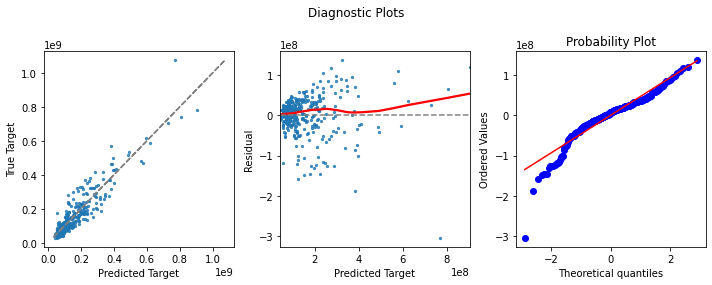

In [120]:
diagnostic_plots(lr_poly.predict(X_train_poly), y_train)

In [99]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)


In [100]:
lin_reg_est = LinearRegression()

scores = cross_val_score(lin_reg_est, X_train, y_train, cv=kfold)
print(scores)
print("Linear Reg Mean Score: ", np.mean(scores))

# Build the Model
lin_reg_est.fit(X_train, y_train)

[0.86508835 0.83045038 0.74722822 0.8276992  0.86138475]
Linear Reg Mean Score:  0.8263701815319884


LinearRegression()

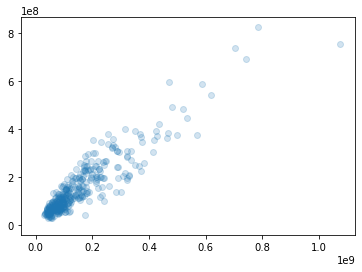

In [106]:
y_train_pred = lin_reg_est.predict(X_train)

plt.scatter(y_train, y_train_pred, alpha=0.2)
plt.plot([0, 400], [0, 400])

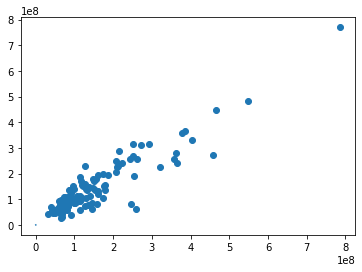

In [105]:
y_test_pred = lin_reg_est.predict(X_val)

plt.scatter(y_val, y_test_pred)
plt.plot([0, 400], [0, 400])

Text(0.5, 1.0, 'Residuals vs. Predictions')

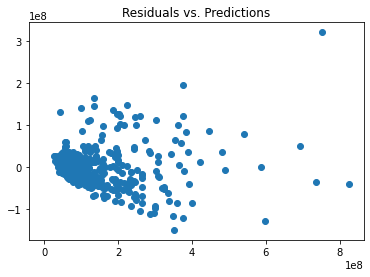

In [107]:
lin_reg_residuals = y_train - y_train_pred

plt.scatter(y_train_pred, lin_reg_residuals)
plt.plot([0,400], [0, 0])
plt.title("Residuals vs. Predictions")

In [109]:
movie_df['months'] = pd.DatetimeIndex(movie_df['release_date']).month


                   movie_title  year  domestic_total_gross  \
0    The Passion of the Christ  2004             370782930   
1                     Deadpool  2016             363070709   
2              American Sniper  2014             350126372   
3                        Joker  2019             335451311   
4                           It  2017             328828874   
..                         ...   ...                   ...   
980                  Moonlight  2016              27854932   
981                      Crank  2006              27838408   
983                 Sinister 2  2015              27740955   
985                     Oculus  2014              27695246   
986                     Saw VI  2009              27693292   

     international_total_gross  worldwide_total_gross    opening    budget  \
0                    241271576              612054506   83848082  30000000   
1                    419766082              782836791  132434639  58000000   
2                    

<ipython-input-109-f8a7a0597680>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df['months'] = pd.DatetimeIndex(movie_df['release_date']).month


In [110]:
movie_df

,movie_title,year,domestic_total_gross,international_total_gross,worldwide_total_gross,opening,budget,runtime_minutes,rating,release_date,months
0,The Passion of the Christ,2004,370782930,241271576,612054506,83848082,30000000,127.0,R,2004-02-25,2
1,Deadpool,2016,363070709,419766082,782836791,132434639,58000000,108.0,R,2016-02-09,2
2,American Sniper,2014,350126372,197300000,547426372,633456,58800000,133.0,R,2014-12-25,12
3,Joker,2019,335451311,738968073,1074419384,96202337,55000000,122.0,R,2019-10-02,10
4,It,2017,328828874,372967570,701796444,123403419,35000000,135.0,R,2017-09-06,9
...,...,...,...,...,...,...,...,...,...,...,...
980,Moonlight,2016,27854932,37481671,65336603,402075,4000000,111.0,R,2016-10-21,10
981,Crank,2006,27838408,15092633,42931041,10457367,12000000,88.0,R,2006-08-31,8
983,Sinister 2,2015,27740955,25588195,53329150,10542116,10000000,97.0,R,2015-08-19,8
985,Oculus,2014,27695246,16764705,44459951,12005402,5000000,104.0,R,2014-04-09,4
